In [8]:
import pandas as pd
import numpy as np

# Step 1: Specify the path to `BM2425.xlsx` in your local system
file_path = '/Users/marclambertes/Python/Matches/Women/2024-2025/Leagues - Project/Pass/France - Pass.xlsx'  # Update with the actual file path on your system

# Step 2: Load the file directly from the local system
data = pd.read_excel(file_path, usecols=['playerName', 'contestantId', 'x', 'y', 'endX', 'endY', 'outcome', 'typeId'], nrows=1000)

# Step 3: Filter for passes (e.g., typeId == 1) and defensive actions (e.g., typeId == 7 or 8)
passes = data[data['typeId'] == 1]  # Assuming typeId == 1 indicates passes
defensive_actions = data[data['typeId'].isin([7, 8])]  # Assuming typeId == 7, 8 are defensive actions

# Identify receivers based on outcome == 1 and next action by a different player
passes['receiverName'] = None
for idx, pass_row in passes.iterrows():
    if pass_row['outcome'] == 1:
        subsequent_actions = data[(data['x'] == pass_row['endX']) & (data['y'] == pass_row['endY']) & (data['playerName'] != pass_row['playerName'])]
        if not subsequent_actions.empty:
            passes.at[idx, 'receiverName'] = subsequent_actions.iloc[0]['playerName']

# Add Pressure successful column
passes['Pressure successful'] = passes['receiverName'].apply(lambda x: 'no' if pd.notna(x) else 'yes')

# Define a threshold for distance calculations
threshold = 10  # Define a threshold in meters

# Function to calculate distance weight
def calculate_distance_weight(distance, max_distance=threshold):
    return max(0, 1 - distance / max_distance)  # Weight decreases linearly with distance

matched_actions = []

for _, pass_row in passes.iterrows():
    for _, def_row in defensive_actions.iterrows():
        # Ensure defender belongs to a different contestantId
        if pass_row['contestantId'] != def_row['contestantId']:
            # Check spatial proximity
            distance = np.sqrt((pass_row['endX'] - def_row['x']) ** 2 + (pass_row['endY'] - def_row['y']) ** 2)
            if distance <= threshold:
                # Calculate metrics
                pre_action_danger = 1 - (
                    0.02 * distance +
                    0.1 * np.abs(np.arctan2(pass_row['endY'] - pass_row['y'], pass_row['endX'] - pass_row['x']))
                )
                pre_action_danger = max(0, min(1, pre_action_danger))  # Clip between 0 and 1
                post_action_danger = pre_action_danger * (0.5 if def_row['outcome'] == 1 else 1.0)

                # Calculate distance weight
                distance_weight = calculate_distance_weight(distance)

                # Adjust xDef with distance weight
                xDef = (pre_action_danger - post_action_danger) * distance_weight

                # Calculate xPass for the pass
                xPass = 1 - (
                    0.02 * distance +
                    0.1 * np.abs(np.arctan2(pass_row['endY'] - pass_row['y'], pass_row['endX'] - pass_row['x']))
                )
                xPass = max(0, min(1, xPass))  # Clip xPass to be between 0 and 1

                matched_actions.append({
                    'passer': pass_row['playerName'],
                    'receiver': pass_row['receiverName'],
                    'Pressure successful': pass_row['Pressure successful'],
                    'defender': def_row['playerName'],
                    'xPass': xPass,
                    'pre_action_danger': pre_action_danger,
                    'post_action_danger': post_action_danger,
                    'xDef': xDef,
                    'distance_weight': distance_weight,
                    'pass_start': (pass_row['x'], pass_row['y']),
                    'pass_end': (pass_row['endX'], pass_row['endY']),
                    'defensive_action': (def_row['x'], def_row['y']),
                    'distance': distance
                })

# Step 4: Save results to a DataFrame
matched_df = pd.DataFrame(matched_actions)

# Step 5: Save results directly to a file in your local system
output_filename = 'Matched_Passes_With_Defensive_Actions_Threshold_10_Meters.xlsx'
matched_df.to_excel(output_filename, index=False)

print(f"Results saved locally at '{output_filename}'")

# Optional: Print a preview of the results
print("Preview of Matched Actions:")
print(matched_df.head())


The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_90819/3080260880.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes['receiverName'] = None
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_90819/3080260880.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes['Pressure successful'] = passes['receiverName'].apply(lambda x: 'no' if pd.notna(x) else 'yes')


Results saved locally at 'Matched_Passes_With_Defensive_Actions_Threshold_10_Meters.xlsx'
Preview of Matched Actions:
            passer receiver Pressure successful       defender     xPass  \
0      E. Guessand     None                 yes      J. Lefort  0.596411   
1      E. Guessand     None                 yes      J. Aholou  0.577229   
2  Y. Ndayishimiye     None                 yes  C. Hountondji  0.650183   
3  Y. Ndayishimiye     None                 yes      J. Lefort  0.684623   
4      T. Ndombélé     None                 yes    Y. Belkhdim  0.582878   

   pre_action_danger  post_action_danger      xDef  distance_weight  \
0           0.596411            0.298205  0.032200         0.107980   
1           0.577229            0.288615  0.003484         0.012073   
2           0.650183            0.325092  0.010894         0.033512   
3           0.684623            0.684623  0.000000         0.205708   
4           0.582878            0.582878  0.000000         0.118581   

In [7]:
import pandas as pd
import numpy as np

# Step 2: Specify the path to `BM2425.xlsx` in Google Drive
file_path = '/Users/marclambertes/Downloads/Wyscout/Pass.xlsx'

# Step 3: Load the file directly from Google Drive
data = pd.read_excel(file_path, usecols=['playerName', 'contestantId', 'x', 'y', 'endX', 'endY', 'typeId'], nrows=1000)

# Step 4: Filter for passes (e.g., typeId == 1)
passes = data[data['typeId'] == 1]  # Assuming typeId == 1 indicates passes

# Define proximity threshold
proximity_threshold = 10  # Define a threshold in meters

# Function to calculate distance weight
def calculate_distance_weight(distance, max_distance=proximity_threshold):
    return max(0, 1 - distance / max_distance)  # Weight decreases linearly with distance

# Process each pass for metrics
calculated_metrics = []

for _, pass_row in passes.iterrows():
    # Calculate spatial metrics and weights
    distance = np.sqrt((pass_row['endX'] - pass_row['x']) ** 2 + (pass_row['endY'] - pass_row['y']) ** 2)

    # Calculate metrics
    pre_action_danger = 1 - (
        0.02 * distance +
        0.1 * np.abs(np.arctan2(pass_row['endY'] - pass_row['y'], pass_row['endX'] - pass_row['x']))
    )
    pre_action_danger = max(0, min(1, pre_action_danger))  # Clip between 0 and 1
    post_action_danger = pre_action_danger * 0.5  # Simplified assumption

    # Calculate distance weight
    distance_weight = calculate_distance_weight(distance)

    # Calculate xPass for the pass
    xPass = 1 - (
        0.02 * distance +
        0.1 * np.abs(np.arctan2(pass_row['endY'] - pass_row['y'], pass_row['endX'] - pass_row['x']))
    )
    xPass = max(0, min(1, xPass))  # Clip xPass to be between 0 and 1

    # Calculate xDef based on pre and post action danger and distance weight
    xDef = (pre_action_danger - post_action_danger) * distance_weight

    calculated_metrics.append({
        'passer': pass_row['playerName'],
        'xPass': xPass,
        'pre_action_danger': pre_action_danger,
        'post_action_danger': post_action_danger,
        'xDef': xDef,
        'distance_weight': distance_weight,
        'pass_start': (pass_row['x'], pass_row['y']),
        'pass_end': (pass_row['endX'], pass_row['endY']),
        'distance': distance
    })

# Step 6: Save results to a DataFrame
calculated_df = pd.DataFrame(calculated_metrics)

# Step 7: Save results directly to Google Drive
output_filename = 'xPASS - Eredivisie.xlsx'
calculated_df.to_excel(output_filename, index=False)

print(f"Results saved directly to Google Drive at '{output_filename}'")

# Optional: Print a preview of the results
print("Preview of Calculated Metrics:")
print(calculated_df.head())


Results saved directly to Google Drive at 'xPASS - Eredivisie.xlsx'
Preview of Calculated Metrics:
        passer     xPass  pre_action_danger  post_action_danger  xDef  \
0       G. Til  0.472822           0.472822            0.236411   0.0   
1   J. Veerman  0.604520           0.604520            0.302260   0.0   
2   M. Tillman  0.489346           0.489346            0.244673   0.0   
3  O. Boscagli  0.551968           0.551968            0.275984   0.0   
4      M. Dams  0.558733           0.558733            0.279367   0.0   

   distance_weight    pass_start      pass_end   distance  
0              0.0  (50.2, 50.0)  (38.6, 44.2)  12.969194  
1              0.0  (38.6, 44.2)  (41.4, 56.9)  13.004999  
2              0.0  (41.4, 56.9)  (31.0, 55.5)  10.493808  
3              0.0  (31.0, 55.5)  (34.8, 70.8)  15.764834  
4              0.0  (35.1, 70.8)  (32.1, 58.1)  13.049521  


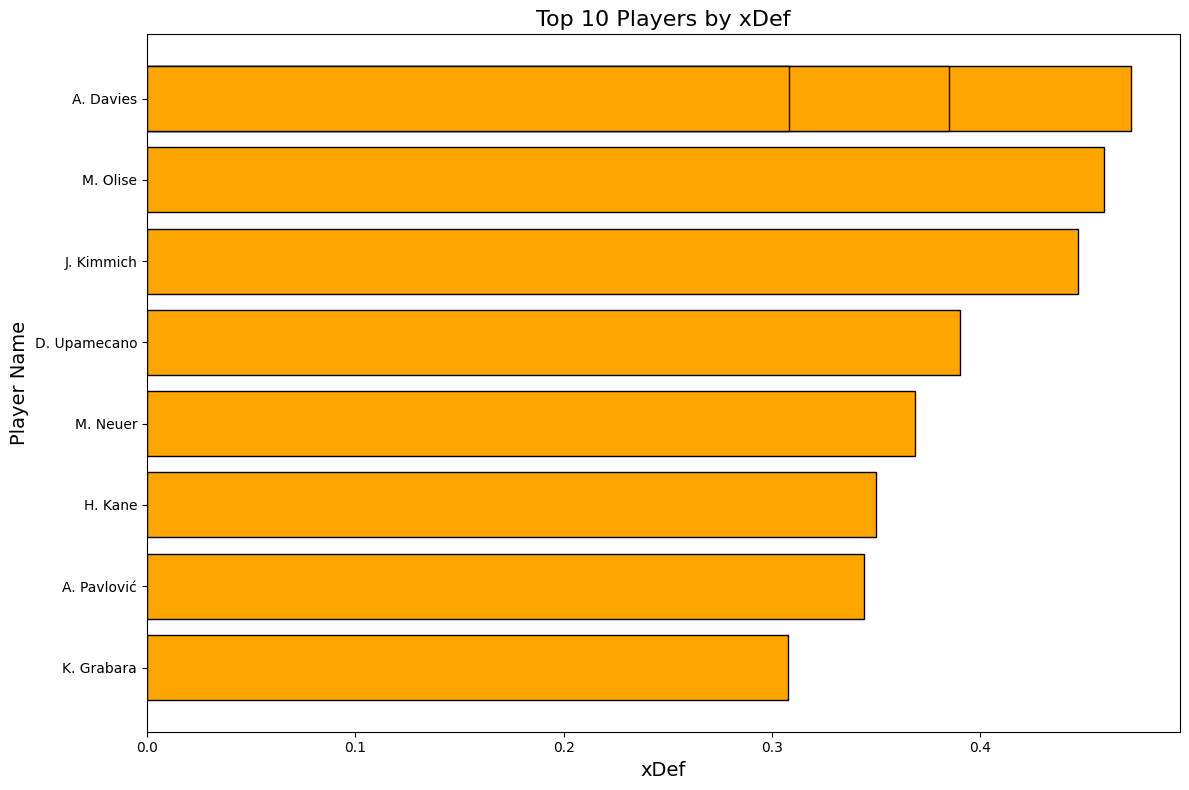

In [5]:
import matplotlib.pyplot as plt

# Load the Excel file
input_file = 'Matched_Passes_Defensive_Actions_With_Weights.xlsx'  # Replace with your input file name
data = pd.read_excel(input_file, index_col=0)# Sort by Attack_Score
top_attackers = matched_df.sort_values(by='xDef', ascending=False).head(10)

# Plot bar chart
plt.figure(figsize=(12, 8))
plt.barh(top_attackers['passer'], top_attackers['xDef'], color='orange', edgecolor='black')
plt.xlabel('xDef', fontsize=14)
plt.ylabel('Player Name', fontsize=14)
plt.title('Top 10 Players by xDef', fontsize=16)
plt.gca().invert_yaxis()  # Invert Y-axis for better readability
plt.tight_layout()
plt.show()